#### CSC 215 Artificial Intelligence (Spring 2023)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 17: Transfer Learning on Natural Language Processing (a COVID-19 example)


In [3]:
# do this in Google Colab

!pip install --upgrade gensim
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [1]:
import json
from gensim.models import Word2Vec
import gensim
import numpy as np
from scipy import spatial
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.models import KeyedVectors

import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import os
import pandas as pd
from gensim import corpora
from pprint import pprint
from gensim.utils import simple_preprocess


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dataset used


https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

You can download a cleaned subset of dataset "all_raw_articles.txt" on Canvas and then upload it to Colab


## Mount Google drive to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Create and train model from scratch out of our COVID-19 dataset

### Create and train model
- Create a word2vec model and train it with the corpus
- Key parameter description (https://radimrehurek.com/gensim/models/word2vec.html)
    - **sentences**: training data (***has to be a list with tokenized sentences***)
    - **vector_size (formerly: size)**: dimension of embedding space
    - **sg**: Continuous Bag-of-Words model (CBOW) if 0 and the Skip-Gram model if 1. CBOW creates a sliding window around current word, to predict it from “context” — the surrounding words.  Skip-Gram model is actaully the opposite of CBOW. Instead of prediciting one word each time, we use 1 word to predict all surrounding words (“context”). 
    - **window**: number of words accounted for each context (if the window size is 3, 3 word in the left neighorhood and 3 word in the right neighborhood are considered)
    - **min_count**: Ignores all words with total frequency lower than this
    - **epochs (formerly: iter)**: number of training iterations
    - **workers**: number of worker threads to train (if multicore machines)
    
For details,  go to http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/    
    

In [3]:
max_sentence_len = 40

with open("drive/MyDrive/Colab Notebooks/215/all_raw_articles.txt", encoding = 'utf-8') as file_:
    docs = file_.readlines()
    
sentences = [[word for word in doc.lower().translate(str.maketrans('','',string.punctuation)).split()[:max_sentence_len]] for doc in docs]
print('Num sentences:', len(sentences))


Num sentences: 45641


In [4]:
sentences[0]

['globally',
 'titanium',
 'dioxide',
 'nanoparticles',
 'tio2nps',
 'are',
 'among',
 'the',
 'most',
 'widely',
 'produced',
 'and',
 'used',
 'nanomaterials',
 'nms',
 'the',
 'estimated',
 'global',
 'annual',
 'production',
 'of',
 'tio2nps',
 'is',
 'currently',
 'near',
 '12500',
 'tons',
 '12',
 'this',
 'value',
 'is',
 'expected',
 'to',
 'reach',
 '25',
 'million',
 'metric',
 'tons',
 'by',
 '2025']

In [ ]:
# this code takes about 3-5 mins

print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, vector_size=300, min_count=5, sg=1, window=5, epochs=100)

pretrained_weights = word_model.wv.vectors

vocab_size, emdedding_size = pretrained_weights.shape



Training word2vec...


### Save and load model
- word2vec model can be saved and loaded locally
- Doing so can reduce time to train model again

In [ ]:
word_model.save('word2vec_model_scratch')

In [ ]:
word_model = Word2Vec.load('word2vec_model_scratch')

### Test the model


In [ ]:
word_model.wv.similar_by_word('coronavirus')

[('229e', 0.45494067668914795),
 ('alphacoronavirus', 0.363269180059433),
 ('positivesense', 0.36013272404670715),
 ('coronaviridae', 0.3521665334701538),
 ('cov', 0.3470074236392975),
 ('enteric', 0.34311020374298096),
 ('feline', 0.34135347604751587),
 ('parainfluenza', 0.33307746052742004),
 ('bocavirus', 0.33228832483291626),
 ('fcov', 0.33221757411956787)]

In [ ]:
word_model.wv.similar_by_word('symptoms')

[('sore', 0.37610679864883423),
 ('signs', 0.37060874700546265),
 ('fever', 0.3660210072994232),
 ('diarrhea', 0.3563969135284424),
 ('bronchopneumonia', 0.3402290940284729),
 ('headache', 0.3362838625907898),
 ('clinical', 0.3353123068809509),
 ('chills', 0.31966760754585266),
 ('afebrile', 0.3196461796760559),
 ('indistinguishable', 0.3160141110420227)]

In [ ]:
v1 = word_model.wv['coronavirus']
v2 = word_model.wv['bats']
# define a function that computes cosine similarity between two words
def cosine_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

cosine_similarity(v1, v2)

0.18185466527938843

In [ ]:
word_model.wv.most_similar(positive=['coronavirus', 'symptoms'])

[('229e', 0.3837372064590454),
 ('syndrome', 0.36894330382347107),
 ('egos', 0.3585277199745178),
 ('diarrhea', 0.35492101311683655),
 ('bordetella', 0.354558527469635),
 ('bev', 0.3538719713687897),
 ('marburg', 0.3537840247154236),
 ('positivesense', 0.3517236113548279),
 ('indistinguishable', 0.3505419194698334),
 ('fcov', 0.34858787059783936)]

### Plot similar words in 2D space

In [14]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


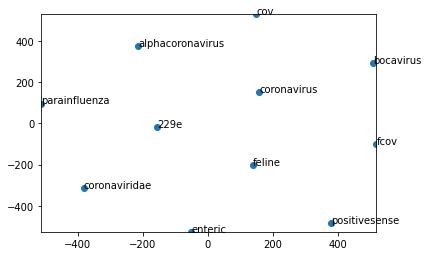

In [ ]:
display_closestwords_tsnescatterplot(word_model,'coronavirus')   

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


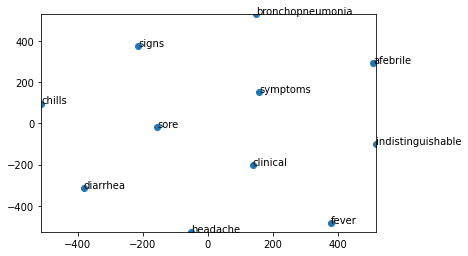

In [ ]:
display_closestwords_tsnescatterplot(word_model,'symptoms')   

## 2. Load Google pre-trained word2vec model (Transfer Learning)



### Download pre-trained word embeddings:  


* [GoogleNews Vectors](https://code.google.com/archive/p/word2vec/), [GitHub Mirror](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

* [Stanford GloVe](https://nlp.stanford.edu/projects/glove/)

#### Load the word2vec model pre-trained on Google News corpus (3 billion running words) (3 million 300-dimension English word vectors).

Download link: https://github.com/mmihaltz/word2vec-GoogleNews-vectors


In [5]:
# this may take 1 min

#word2vec Google model - need 1.7 GB file
filename = 'drive/MyDrive/Colab Notebooks/215/GoogleNews-vectors-negative300.bin.gz'
model2 = KeyedVectors.load_word2vec_format(filename, binary=True)


In [6]:
model2.most_similar(positive=['coronavirus'], topn=10)

[('corona_virus', 0.7276226878166199),
 ('coronaviruses', 0.7216538190841675),
 ('paramyxovirus', 0.7113004326820374),
 ('SARS_coronavirus', 0.660190761089325),
 ('arenavirus', 0.6494410634040833),
 ('influenza_virus', 0.6449827551841736),
 ('H#N#_subtype', 0.6360140442848206),
 ('H#N#_strain', 0.6324742436408997),
 ('H7_virus', 0.6261192560195923),
 ('flu_virus', 0.6249204277992249)]

In [7]:
model2.most_similar(negative=['symptoms'], topn=10)

[('Business_BusinessNews', 0.26465803384780884),
 ('CROW_AGENCY_Mont', 0.25890251994132996),
 ('MINNESOTA_NEWS', 0.23259694874286652),
 ('E.Sadler_###-###', 0.2224021852016449),
 ('Federale', 0.22036875784397125),
 ('Sy_Schlueter_chief', 0.21728844940662384),
 ('M.Kenseth_###-###', 0.2157689332962036),
 ('Penalties_None', 0.21527300775051117),
 ('By_Claudia_Liburd', 0.2126707285642624),
 ('Abrams_M#A#_tank', 0.21011163294315338)]

### Fine-tune Google's pre-trained word2vec embeddings on our COVID-19 dataset


https://radimrehurek.com/gensim/models/word2vec.html



#### 1. build_vocab() to build vocabulary. 




#### 2. intersect_word2vec_format() merges in an input-hidden weight matrix loaded from the original C word2vec-tool format, where it intersects with the current vocabulary.

No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.

In [8]:
# this may take 1 min

# size option needs to be set to 300 to be the same as Google's pre-trained model 
word2vec_model = Word2Vec(vector_size=300, min_count=5, sg=1, window=5, epochs=300)


word2vec_model.build_vocab(sentences)

word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))


# assign the vectors to the vocabs that are in Google's pre-trained model and your sentences defined above.
# lockf needs to be set to 1.0 to allow continued training.
word2vec_model.wv.intersect_word2vec_format('drive/MyDrive/Colab Notebooks/215/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

#### 3. train() to update weights/embeddings

train() expects a sequence of sentences on input, not one sentence.

train() only updates weights for existing feature vectors based on existing vocabulary. You cannot add new vocabulary (= new feature vectors) using train().



In [11]:
# this may take 30 seconds

# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.train

word2vec_model.train(sentences,  # our COVID dataset 
                     total_examples=45641,      
                     epochs = 5)

(2728161, 3770420)

In [ ]:
word2vec_model.save('word2vec_model_transfer')

In [ ]:
word2vec_model = Word2Vec.load('word2vec_model_transfer')

In [12]:
word2vec_model.wv.most_similar(positive=['coronavirus'], topn=20)

[('coronaviruses', 0.7216538190841675),
 ('paramyxovirus', 0.6961820721626282),
 ('fecv', 0.6229164004325867),
 ('rhinoviruses', 0.609694242477417),
 ('serotype', 0.5851495265960693),
 ('retrovirus', 0.5848078727722168),
 ('positivesense', 0.577880859375),
 ('influenza', 0.57539302110672),
 ('rhinovirus', 0.575023889541626),
 ('virus', 0.5741950869560242),
 ('toxoplasma', 0.5669514536857605),
 ('herpesvirus', 0.5634392499923706),
 ('metapneumovirus', 0.5535969138145447),
 ('paramyxoviruses', 0.5535460710525513),
 ('babesiosis', 0.5515989065170288),
 ('bocavirus', 0.5511655807495117),
 ('parainfluenza', 0.5493844747543335),
 ('adenoviruses', 0.5452141165733337),
 ('enterovirus', 0.5440385937690735),
 ('flavivirus', 0.5428510904312134)]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


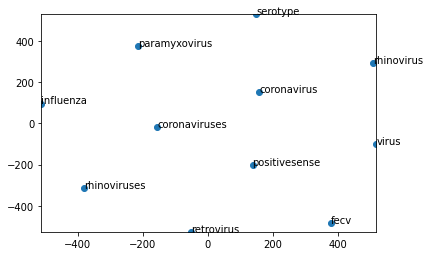

In [15]:
display_closestwords_tsnescatterplot(word2vec_model,'coronavirus')

In [16]:
word2vec_model.wv.most_similar(positive=['symptoms'], topn=20)

[('symptom', 0.6141738295555115),
 ('vomiting', 0.6136192083358765),
 ('nausea', 0.6018531918525696),
 ('sepsisassociated', 0.5818195939064026),
 ('shortness', 0.5731192231178284),
 ('abnormalities', 0.5617275238037109),
 ('fevers', 0.5584895014762878),
 ('headache', 0.5564916729927063),
 ('thyroiditis', 0.548612117767334),
 ('non‐specific', 0.54228276014328),
 ('dyspnea', 0.5413785576820374),
 ('afebrile', 0.5311680436134338),
 ('constipation', 0.5230088829994202),
 ('jaundice', 0.5204572677612305),
 ('ataxia', 0.5193161368370056),
 ('tachypnea', 0.5190548300743103),
 ('illnesses', 0.5151292085647583),
 ('meningoencephalitis', 0.5131151676177979),
 ('pcd', 0.5116012096405029),
 ('retroorbital', 0.5114557147026062)]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


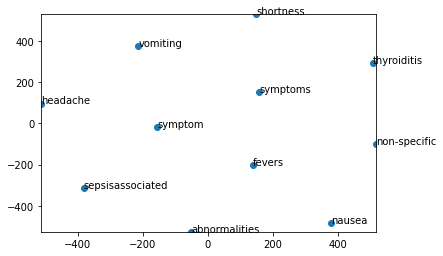

In [17]:
display_closestwords_tsnescatterplot(word2vec_model,'symptoms')

In [18]:
word2vec_model.wv['coronavirus']

array([-0.45507812,  0.06787109,  0.08496094,  0.12402344, -0.27929688,
       -0.20800781, -0.0133667 , -0.01672363,  0.38867188,  0.33984375,
        0.6640625 , -0.46679688,  0.26757812, -0.01373291, -0.68359375,
        0.4609375 , -0.20703125,  0.44140625,  0.09521484, -0.24707031,
        0.20800781, -0.36523438,  0.04272461, -0.15039062, -0.02624512,
        0.05053711, -0.10986328, -0.41796875,  0.40039062,  0.06079102,
       -0.51953125, -0.58984375,  0.734375  , -0.12890625,  0.01544189,
        0.13476562, -0.328125  ,  0.17089844,  0.42773438,  0.52734375,
       -0.01953125, -0.3828125 , -0.58984375,  0.63671875,  0.05151367,
       -0.37109375,  0.21484375,  0.1875    , -0.22949219,  0.31054688,
       -0.04882812, -0.21679688, -0.11523438, -0.13769531, -0.234375  ,
        0.44140625, -0.22460938,  0.21875   ,  0.10107422,  0.23535156,
        0.15136719,  0.49609375, -0.14355469,  0.12011719,  0.11474609,
       -0.37109375,  0.1953125 , -0.32226562, -0.20996094,  0.77

### Now you can feed the learned embeddings to your NN/CNN/RNN models as input

## Bonus:  emoji2vec

https://github.com/uclnlp/emoji2vec

emoji2vec: Learning Emoji Representations from their Description the paper recently released by Ben Eisner, Tim Rocktäschel, Isabelle Augenstein, Matko Bošnjak, and Sebastian Riedel.

In [19]:
e2v = KeyedVectors.load_word2vec_format('drive/MyDrive/Colab Notebooks/215/emoji2vec.bin', binary=True)


happy_vector = e2v['😂']    # Produces an embedding vector of length 300

In [20]:
happy_vector 

array([ 0.00368995, -0.00747812,  0.04797658,  0.0592004 , -0.0594517 ,
       -0.01919357,  0.06628808, -0.06752758,  0.10211562,  0.087887  ,
       -0.02949324, -0.07718539, -0.07068242,  0.04688684, -0.07970048,
        0.09425059,  0.06230384,  0.09221437, -0.03019106, -0.08475313,
        0.06153254,  0.08948752,  0.07492744, -0.0697182 ,  0.02842957,
       -0.07775956, -0.00585377, -0.01818646,  0.07633407, -0.09874155,
       -0.05507204,  0.04539224,  0.00842756, -0.06562244, -0.04902945,
       -0.05832005,  0.07070394,  0.05070673,  0.05466724,  0.08123799,
        0.06764334, -0.09264724,  0.07862549, -0.03581576,  0.02264971,
       -0.00622183, -0.0318586 ,  0.0421854 , -0.05610641,  0.07420981,
       -0.06671992, -0.05842454,  0.03449175,  0.07620545,  0.08768762,
        0.03041447, -0.05500258, -0.03190211,  0.07291865, -0.04514114,
       -0.0541351 ,  0.05987531, -0.0346354 , -0.01317827,  0.00849659,
       -0.01372368, -0.01279207, -0.01283779, -0.07702036,  0.09

In [21]:
e2v.most_similar(positive=['😂'], topn=10)

[('😹', 0.8721947073936462),
 ('😃', 0.6930503845214844),
 ('😆', 0.6827422976493835),
 ('😭', 0.671003520488739),
 ('😿', 0.6530010104179382),
 ('😢', 0.6413196921348572),
 ('😺', 0.619818925857544),
 ('😀', 0.5949568152427673),
 ('😊', 0.5913735032081604),
 ('☺️', 0.5856199264526367)]

In [22]:
e2v.most_similar(negative=['😂'], topn=10)

[('⏳', 0.12211214005947113),
 ('👰🏿', 0.11871223896741867),
 ('☸', 0.09855016320943832),
 ('🙍🏻', 0.0953911617398262),
 ('🙏🏿', 0.07736988365650177),
 ('🔲', 0.07499483972787857),
 ('⚾️', 0.07397320866584778),
 ('🤜', 0.070037342607975),
 ('💇🏽', 0.0686764121055603),
 ('👩\u200d👩\u200d👧\u200d👦', 0.05706221982836723)]

In [23]:
#word2vec Google model - need 1.7GB file
#filename = 'drive/MyDrive/Colab Notebooks/215/GoogleNews-vectors-negative300.bin.gz'
#model2 = KeyedVectors.load_word2vec_format(filename, binary=True)

In [24]:
v1 = e2v['😂']
v2 = model2['happy']
# define a function that computes cosine similarity between two words
def cosine_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

cosine_similarity(v1, v2)

0.5871525406837463

### Appendix:   code for preprocessing the COVID-19 data

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

In [ ]:
# reading raw JSON files into a txt file

def readFiles(directory_list):
  json_dict = {}
  sentence = []
  tokens = []
  f = open("all_raw_articles.txt", "a")
  count = 0
  for directory in directory_list:
    for filename in os.listdir(directory):
        full_file_path = os.path.join(directory, filename)
        with open (full_file_path) as json_file:
          data = json.load(json_file)
          for body_index, x in enumerate (data['body_text']):
            for text_index, i in enumerate (data['body_text'][body_index]['text']):
              f.write(data["body_text"][body_index]["text"][text_index])
              sentence.append(data['body_text'][body_index]['text'][text_index])
              tokens.append(simple_preprocess(sentence[count]))
              count +=1

  f.close()
  return tokens       

directory_list = ['/content/drive//My Drive/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pmc_json/',
                  '/content/drive//My Drive/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/',
                  '/content/drive//My Drive/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json/']

#Get the words as tokens from reading JSON files
tokens = readFiles(directory_list)
